In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy import stats
from scipy.fftpack import fft, ifft
import bisect 
from scipy import signal
import pandas as pd
import seaborn as sns
from cdt.metrics import SHD
from cdt.metrics import precision_recall
import time
import random
import heapq
import lingam
import warnings

from spikegraph import *
from helpers import *

warnings.filterwarnings("ignore")

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
fn1='data/groundtruth/toyexample5nodegt.txt'
gt = getGroundTruth(fn1)

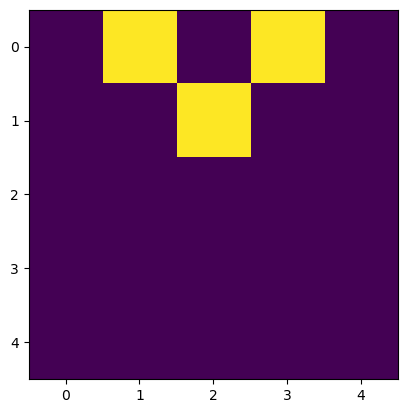

In [3]:
plt.imshow(gt)

K, T: (814, 21)
Unique elements and their counts:
Element: 0, Count: 14121
Element: 16, Count: 860
Element: 8, Count: 285
Element: 2, Count: 315
Element: 18, Count: 193
Element: 4, Count: 252
Element: 25, Count: 42
Element: 24, Count: 315
Element: 12, Count: 147
Element: 1, Count: 459
Element: 9, Count: 21
Element: 14, Count: 21
Element: 17, Count: 21
Element: 10, Count: 21
Element: 30, Count: 21
Counter({0: 14121, 16: 860, 1: 459, 2: 315, 24: 315, 8: 285, 4: 252, 18: 193, 12: 147, 25: 42, 9: 21, 14: 21, 17: 21, 10: 21, 30: 21})
[tab] 0000  tot=3.4636  var=0.0003  nll=3.4633
[tab] 0050  tot=0.6440  var=0.0244  nll=0.6195
[tab] 0100  tot=0.6477  var=0.0097  nll=0.6380
[tab] 0150  tot=0.6473  var=0.0032  nll=0.6441
[tab] 0200  tot=0.8308  var=0.0096  nll=0.8212
[tab] 0250  tot=0.6127  var=0.0038  nll=0.6089
[tab] 0300  tot=0.6441  var=0.0110  nll=0.6330
[tab] 0350  tot=0.7945  var=0.0144  nll=0.7801
[tab] 0400  tot=0.6453  var=0.0030  nll=0.6423
[tab] 0450  tot=0.7620  var=0.0241  nll=0.

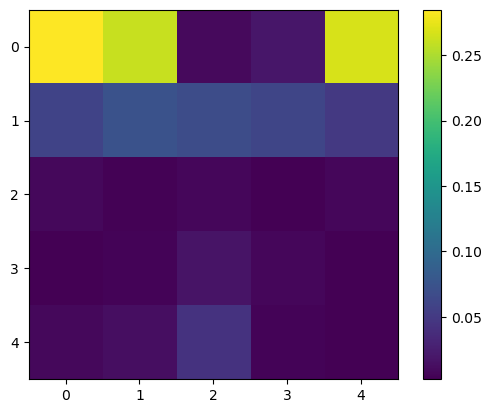

In [4]:
fn2 = 'data/spiketrainsfromNEURON/toyexample5nodesamples/rasterplot-5node_30.txt'

duration = 5000
N = 5
h = 6
T = 20
states_np, idx = enumerate_states(N)

numSpikes, spikeTimes = getSpikesInfo(fn2)
data = getBinarizedSpikeMatrix(spikeTimes, 5, N, h)
paths = prepare_paths_from_spikes(data, T)

K, T = np.shape(paths)
print(f"K, T: {K, T}")
print(count_unique_elements(paths))

@dataclass
class CFG:
    N: int = N
    T: int = T
    K: int = K
    seed: int = 123
    lr_tab: float = 1e-1
    iters_tab: int = 500
    lr_nn: float = 3e-4
    iters_nn: int = 1500
    hidden: int = 64
    batch_m: int = 256
    nll_coeff: float = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG(N=N, T=T-1, K=K)
device = torch.device(cfg.device)
paths_t = torch.tensor(paths, device=device)

# Train transition matrix
P_tab, loss_tab_tot, loss_tab_var, loss_tab_nll = train_tabular(cfg, states_np, paths_t, device)

Δ_tab = influence(P_tab, states_np); Adj_tab = adjacency(Δ_tab)

plt.imshow(Δ_tab)
plt.colorbar()

In [5]:
P_tab @ (states_np==1).astype(float)

array([[0.05399932, 0.04696055, 0.02918991, 0.03663746, 0.03664635],
       [0.12680077, 0.06473293, 0.00150637, 0.00153101, 0.00144161],
       [0.49846225, 0.00179832, 0.00180338, 0.00179373, 0.00178398],
       [0.05903389, 0.04330109, 0.03870949, 0.03948731, 0.06650004],
       [0.61876301, 0.99739038, 0.00203387, 0.00197268, 0.20865908],
       [0.0576173 , 0.04258468, 0.03842498, 0.03939694, 0.06478194],
       [0.05839911, 0.04302333, 0.0387215 , 0.03922822, 0.06534565],
       [0.05786642, 0.04264168, 0.03869839, 0.03934304, 0.06346876],
       [0.81457543, 0.0324322 , 0.03244428, 0.00134471, 0.00134802],
       [0.99335733, 0.0030889 , 0.00301301, 0.00300066, 0.00305007],
       [0.99468667, 0.00211591, 0.00219579, 0.00216864, 0.00209209],
       [0.05776048, 0.0428903 , 0.03900027, 0.03970645, 0.0630088 ],
       [0.74177923, 0.00260426, 0.00263392, 0.1555204 , 0.11984405],
       [0.05722328, 0.04219888, 0.03816745, 0.0390314 , 0.06467647],
       [0.99394556, 0.00298429, 0.

In [6]:
states_np

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1]], dtype=int8)

In [7]:
idx

{(0, 0, 0, 0, 0): 0,
 (0, 0, 0, 0, 1): 1,
 (0, 0, 0, 1, 0): 2,
 (0, 0, 0, 1, 1): 3,
 (0, 0, 1, 0, 0): 4,
 (0, 0, 1, 0, 1): 5,
 (0, 0, 1, 1, 0): 6,
 (0, 0, 1, 1, 1): 7,
 (0, 1, 0, 0, 0): 8,
 (0, 1, 0, 0, 1): 9,
 (0, 1, 0, 1, 0): 10,
 (0, 1, 0, 1, 1): 11,
 (0, 1, 1, 0, 0): 12,
 (0, 1, 1, 0, 1): 13,
 (0, 1, 1, 1, 0): 14,
 (0, 1, 1, 1, 1): 15,
 (1, 0, 0, 0, 0): 16,
 (1, 0, 0, 0, 1): 17,
 (1, 0, 0, 1, 0): 18,
 (1, 0, 0, 1, 1): 19,
 (1, 0, 1, 0, 0): 20,
 (1, 0, 1, 0, 1): 21,
 (1, 0, 1, 1, 0): 22,
 (1, 0, 1, 1, 1): 23,
 (1, 1, 0, 0, 0): 24,
 (1, 1, 0, 0, 1): 25,
 (1, 1, 0, 1, 0): 26,
 (1, 1, 0, 1, 1): 27,
 (1, 1, 1, 0, 0): 28,
 (1, 1, 1, 0, 1): 29,
 (1, 1, 1, 1, 0): 30,
 (1, 1, 1, 1, 1): 31}